In [3]:
import pandas as pd
import numpy as np
import  tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import keras
import pandas as pd
import numpy as np
import os
import  tensorflow as tf
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.ops.gen_batch_ops import Batch

In [4]:
# Load the CSV file
file_path = '/mnt/c/Users/borbe/PyCharmMiscProject/games.csv'
df = pd.read_csv(file_path)

# Remove completely identical rows
df = df.drop_duplicates()

df = df[(df['turns'] >= 20)]

# Drop the specified columns
columns_to_remove = [
    'id', 'rated', 'created_at', 'last_move_at', 'turns'
    'victory_status', 'increment_code', 'white_id', 'white_rating',
    'black_id', 'black_rating', 'opening_eco'
]
df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')

def truncate_moves(moves_str, max_moves=20):
    moves = moves_str.split()
    return ' '.join(moves[:max_moves])

df_cleaned['moves'] = df_cleaned['moves'].apply(truncate_moves)

# Display the final cleaned DataFrame

print (len (df_cleaned['moves'].values[11000].split(' ')))

# Split the 'moves' column into separate columns
moves_split = df_cleaned['moves'].str.split(expand=True)

# Optionally rename the columns to something like 'move_1', 'move_2', ...
moves_split.columns = [f'move_{i+1}' for i in range(moves_split.shape[1])]

# Join the split move columns back with the original DataFrame (excluding old 'moves' column)
df_cleaned = df_cleaned.drop(columns=['moves']).join(moves_split)

move_cols = df.columns[:-1]
label_col = 'white_won'
unique_moves = set(df_cleaned[moves_split.columns].values.flatten())
le = LabelEncoder()
le.fit(list(unique_moves))

encoded_columns = [le.transform(df_cleaned[col].values) for col in moves_split.columns]

embed_model = keras.Sequential()
embed_model.add(keras.layers.Embedding(len(unique_moves), 10))

input_array = np.array(encoded_columns)
embed_model.compile('rmsprop', 'mse')
output_array =embed_model.predict(input_array)
X = output_array
Y = df['winner'].values


win_encoder = OneHotEncoder(sparse_output=False)
Y = win_encoder.fit_transform(Y.reshape(-1,1))

# raw = model.predict(X_in)
X_emb = output_array.T.reshape(-1,output_array.shape[1]).T
print(X_emb.shape)

X=X_emb
print(Y.shape)
X

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/borbe/PyCharmMiscProject/games.csv'

In [346]:
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.2, random_state=41)

In [347]:
##create model
# from keras.layers import BatchNormalization
# inputs = Input(shape=(X_train.shape[1],))
#
# x = Dense(512, activation='relu')(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
#
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
#
# # from tensorflow.keras.regularizers import l2
# # Dense(256, activation='relu',
# #       kernel_regularizer=l2(1e-4))
#
#
# outputs = Dense(3,activation='softmax')(x)
#
# model = Model(inputs=inputs, outputs=outputs)
#
# model.compile(optimizer=tf.keras.optimizers.Adam(0.001 , clipnorm=1.0
#     # learning_rate=0.01,   # step size for each update
#     # momentum=0.9,         # accelerates convergence, dampens oscillations
#     # nesterov=True        # set True to enable Nesterov momentum
# ), loss='categorical_crossentropy', metrics=['mae','mse', 'accuracy'])




from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_dim = X_train.shape[1]   # e.g. number of features after embedding
inputs = Input(shape=(input_dim,))

# Block 1
x = Dense(512, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Block 2
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Optional Block 3 (smaller, to force a bottleneck)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)



# Output layer
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile with a lower learning‐rate Adam and only accuracy as a metric
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_91 (InputLayer)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,787 (1.92 MB)

 Trainable params: 500,227 (1.91 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [348]:
model.summary()

Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_91 (InputLayer)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,787 (1.92 MB)

 Trainable params: 500,227 (1.91 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [349]:
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=50,
#         restore_best_weights=True,
#         verbose=1,
#     ),
#      tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=20,
#         min_lr=1e-10,
#         verbose=1,
#         # cooldown=1,
#     )
# ]

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    # Bail out soon once val_loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=15,               # ↓ from 50 → 12
        restore_best_weights=True,
        verbose=1
    ),

    # Immediately shrink LR when plateauing
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,                # ↓ from 0.5 → 0.2 for steeper cuts
        patience=8,                # ↓ from 20 → 6
        min_lr=1e-6,               # floor at 1e-6
        cooldown=2,                # give 2 epochs after each LR change
        verbose=1
    ),

    # Save the best‐performing weights by val_accuracy
    ModelCheckpoint(
        filepath='best_opening_model.h5',
        monitor='val_accuracy',    # you can also monitor val_loss
        save_best_only=True,
        verbose=1

    )
]



Epoch 1/500
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3379 - loss: 1.9322
Epoch 1: val_accuracy improved from -inf to 0.48654, saving model to best_opening_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3379 - loss: 1.9319 - val_accuracy: 0.4865 - val_loss: 1.1386 - learning_rate: 1.0000e-04
Epoch 2/500
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3719 - loss: 1.6524
Epoch 2: val_accuracy did not improve from 0.48654
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3719 - loss: 1.6522 - val_accuracy: 0.4865 - val_loss: 1.0923 - learning_rate: 1.0000e-04
Epoch 3/500
137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3962 - loss: 1.4995
Epoch 3: val_accuracy did not improve from 0.48654
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3964 - loss: 1.4964 - val_accuracy: 0.4832 - val_loss: 1.0353 - learning_rate: 1.0000e-04
Epoch 4/500
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4137 - loss: 1.3725
Epoch 4: val_accuracy did not improve from 0.48654
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4136 - loss: 1.3722 - val_accuracy: 0.4840 - val_loss: 0.9947 - learning_rate: 1.0000e-04
Epoch

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4183 - loss: 1.3100 - val_accuracy: 0.4876 - val_loss: 0.9736 - learning_rate: 1.0000e-04
Epoch 6/500
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4383 - loss: 1.2309
Epoch 6: val_accuracy improved from 0.48765 to 0.48793, saving model to best_opening_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4381 - loss: 1.2292 - val_accuracy: 0.4879 - val_loss: 0.9506 - learning_rate: 1.0000e-04
Epoch 7/500
131/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4371 - loss: 1.1809
Epoch 7: val_accuracy improved from 0.48793 to 0.48848, saving model to best_opening_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4371 - loss: 1.1797 - val_accuracy: 0.4885 - val_loss: 0.9323 - learning_rate: 1.0000e-04
Epoch 8/500
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4545 - loss: 1.1286
Epoch 8: val_accuracy did not improve from 0.48848
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4545 - loss: 1.1285 - val_accuracy: 0.4874 - val_loss: 0.9181 - learning_rate: 1.0000e-04
Epoch 9/500
 26/151 ━━━━━━━━━━━━━━━━━━━━ 1:01 489ms/step - accuracy: 0.4748 - loss: 1.0689
Epoch 9: val_accuracy did not improve from 0.48848
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s -62us/step - accuracy: 0.4634 - loss: 1.0831 - val_accuracy: 0.4815 - val_loss: 0.9065 - learning_rate: 1.0000e-04
Epoch 10/500
136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4710 - loss: 1.0581
Epoch 10: val_accuracy did not improve from 0.48848
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4713 - loss: 1.0565 - val_accuracy: 0.4802 - val_loss: 0.8967 - learning_rate: 1.0000e-0

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4896 - loss: 0.9318 - val_accuracy: 0.4899 - val_loss: 0.8751 - learning_rate: 1.0000e-04
Epoch 16/500
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4853 - loss: 0.9333
Epoch 16: val_accuracy did not improve from 0.48987
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4857 - loss: 0.9328 - val_accuracy: 0.4857 - val_loss: 0.8738 - learning_rate: 1.0000e-04
Epoch 17/500
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5021 - loss: 0.9211
Epoch 17: val_accuracy did not improve from 0.48987
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5020 - loss: 0.9209 - val_accuracy: 0.4882 - val_loss: 0.8706 - learning_rate: 1.0000e-04
Epoch 18/500
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4995 - loss: 0.9051
Epoch 18: val_accuracy improved from 0.48987 to 0.49098, saving model to best_opening_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4995 - loss: 0.9049 - val_accuracy: 0.4910 - val_loss: 0.8691 - learning_rate: 1.0000e-04
Epoch 19/500
 11/151 ━━━━━━━━━━━━━━━━━━━━ 2:50 1s/step - accuracy: 0.5364 - loss: 0.8960
Epoch 19: val_accuracy improved from 0.49098 to 0.49292, saving model to best_opening_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.5161 - loss: 0.8957 - val_accuracy: 0.4929 - val_loss: 0.8699 - learning_rate: 1.0000e-04
Epoch 20/500
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5134 - loss: 0.8855
Epoch 20: val_accuracy did not improve from 0.49292
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5131 - loss: 0.8860 - val_accuracy: 0.4904 - val_loss: 0.8685 - learning_rate: 1.0000e-04
Epoch 21/500
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4990 - loss: 0.8808
Epoch 21: val_accuracy did not improve from 0.49292
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4993 - loss: 0.8806 - val_accuracy: 0.4901 - val_loss: 0.8679 - learning_rate: 1.0000e-04
Epoch 22/500
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5141 - loss: 0.8768
Epoch 22: val_accuracy improved from 0.49292 to 0.49598, saving model to best_opening_model.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5141 - loss: 0.8766 - val_accuracy: 0.4960 - val_loss: 0.8664 - learning_rate: 1.0000e-04
Epoch 23/500
137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5148 - loss: 0.8613
Epoch 23: val_accuracy did not improve from 0.49598
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5146 - loss: 0.8619 - val_accuracy: 0.4946 - val_loss: 0.8652 - learning_rate: 1.0000e-04
Epoch 24/500
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5092 - loss: 0.8636
Epoch 24: val_accuracy did not improve from 0.49598
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5094 - loss: 0.8636 - val_accuracy: 0.4926 - val_loss: 0.8655 - learning_rate: 1.0000e-04
Epoch 25/500
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5218 - loss: 0.8610
Epoch 25: val_accuracy did not improve from 0.49598
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5218 - loss: 0.8610 - val_accuracy: 0.4954 - val_loss: 0.8656 - learning_rate: 1.0000e-04


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5280 - loss: 0.8564 - val_accuracy: 0.5007 - val_loss: 0.8660 - learning_rate: 1.0000e-04
Epoch 27/500
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5204 - loss: 0.8578
Epoch 27: val_accuracy did not improve from 0.50069
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5208 - loss: 0.8573 - val_accuracy: 0.4982 - val_loss: 0.8660 - learning_rate: 1.0000e-04
Epoch 28/500
127/151 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.5229 - loss: 0.8512
Epoch 28: val_accuracy did not improve from 0.50069
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.5239 - loss: 0.8512 - val_accuracy: 0.4949 - val_loss: 0.8674 - learning_rate: 1.0000e-04
Epoch 29/500
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5346 - loss: 0.8510
Epoch 29: val_accuracy did not improve from 0.50069
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5343 - loss: 0.8511 - val_accuracy: 0.4990 - val_loss: 0.8668 - learning_rate: 1.0000e-

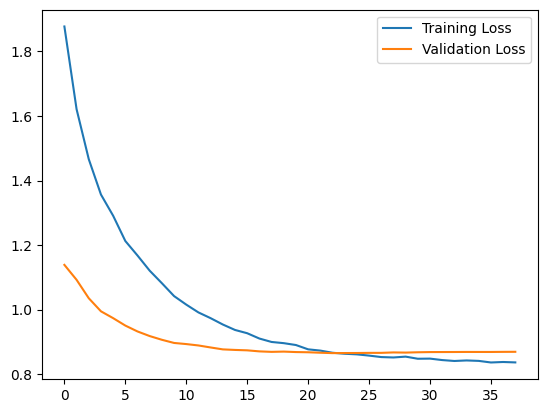

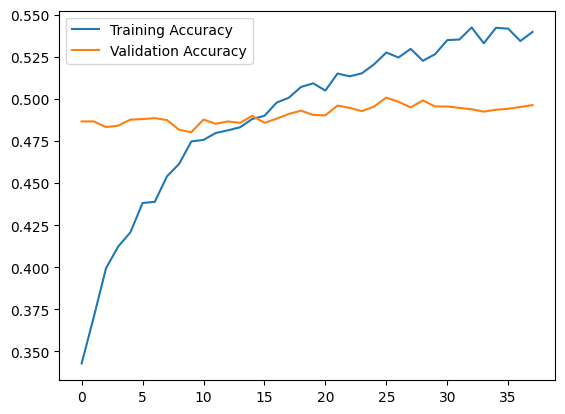

In [350]:
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=500, batch_size=96, verbose=1, callbacks=callbacks)
train = model.evaluate(X_train, y_train)
val = model.evaluate(X_test, y_test)

print('Train accuracy:', train)
print('Validation accuracy:', val)

import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5657 - loss: 0.7964
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4984 - loss: 0.8620
Train accuracy: [0.7982868552207947, 0.5709825158119202]
Validation accuracy: [0.8652322292327881, 0.49486538767814636]


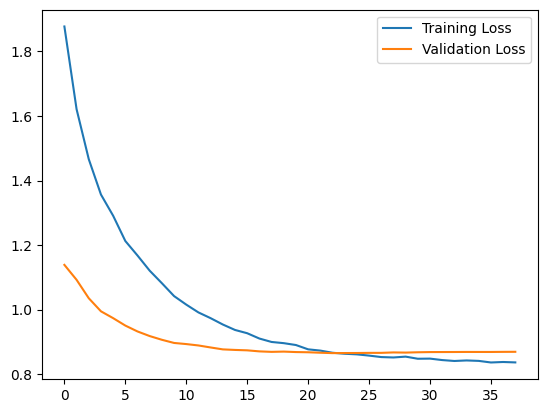

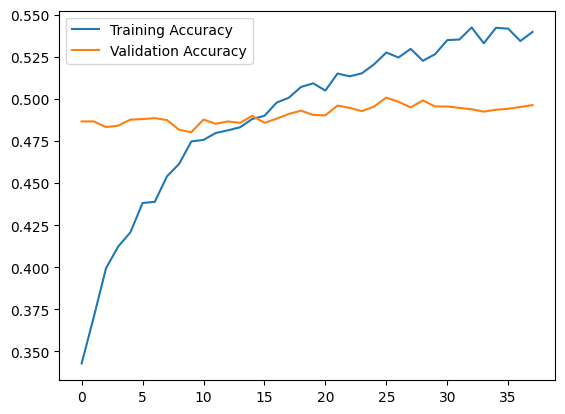

In [351]:
train = model.evaluate(X_train, y_train)
val = model.evaluate(X_test, y_test)

print('Train accuracy:', train)
print('Validation accuracy:', val)

import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [352]:
model.save("/mnt/c/Users/borbe/Desktop/model.keras")
import pickle
with open("/mnt/c/Users/borbe/Desktop/embedmodel", "wb") as f:
    pickle.dump(embed_model, f)
with open("/mnt/c/Users/borbe/Desktop/labelencoder", "wb") as f:
    pickle.dump(le, f)